In [1]:
 !pip install -q efficientnet

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
import efficientnet.tfkeras as efn

In [3]:
train_dir='../input/siic-isic-224x224-images/train/'
test_dir='../input/siic-isic-224x224-images/test/'
df=pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/train.csv')
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [4]:
df.shape

(33126, 8)

In [5]:
df['image_name'].nunique()

33126

Image name is the unique identifier

In [6]:
df['benign_malignant'].value_counts()

benign       32542
malignant      584
Name: benign_malignant, dtype: int64

In [7]:
df['target'].value_counts()

0    32542
1      584
Name: target, dtype: int64

In [8]:
df[df['target']==1]

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
91,ISIC_0149568,IP_0962375,female,55.0,upper extremity,melanoma,malignant,1
235,ISIC_0188432,IP_0135517,female,50.0,upper extremity,melanoma,malignant,1
314,ISIC_0207268,IP_7735373,male,55.0,torso,melanoma,malignant,1
399,ISIC_0232101,IP_8349964,male,65.0,torso,melanoma,malignant,1
459,ISIC_0247330,IP_3232631,female,65.0,lower extremity,melanoma,malignant,1
...,...,...,...,...,...,...,...,...
32969,ISIC_9955163,IP_7507212,male,55.0,upper extremity,melanoma,malignant,1
33000,ISIC_9963177,IP_1165806,male,70.0,torso,melanoma,malignant,1
33014,ISIC_9967383,IP_7887363,male,60.0,upper extremity,melanoma,malignant,1
33050,ISIC_9978107,IP_2860540,male,65.0,lower extremity,melanoma,malignant,1


'Target' is the label column: 0 - benign; 1 - malignant

'Target' and 'benign_malignant' are essentially saying the same. Hence removing the latter.

In [9]:
del df['benign_malignant']

unknown                               27124
nevus                                  5193
melanoma                                584
seborrheic keratosis                    135
lentigo NOS                              44
lichenoid keratosis                      37
solar lentigo                             7
cafe-au-lait macule                       1
atypical melanocytic proliferation        1
Name: diagnosis, dtype: int64


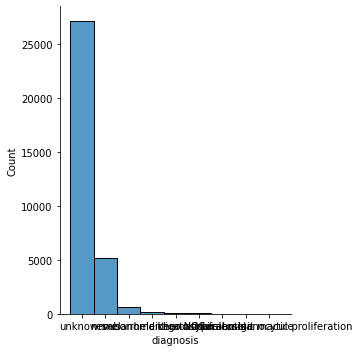

In [10]:
print(df['diagnosis'].value_counts())
sns.displot(data = df, x="diagnosis")

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 1.8+ MB


In [12]:
df.isna().sum()

image_name                         0
patient_id                         0
sex                               65
age_approx                        68
anatom_site_general_challenge    527
diagnosis                          0
target                             0
dtype: int64

There are some null values in 'sex', age_approx' and 'anatom_site_general_challenge' fields. But they do not matter for now as we are only going to use the images and their labels.

In [13]:
df['patient_id'].value_counts()

IP_7279968    115
IP_4382720    115
IP_4938382    115
IP_4479736    115
IP_0656529    114
             ... 
IP_7765635      3
IP_3424938      3
IP_8003098      3
IP_3645134      3
IP_8335299      2
Name: patient_id, Length: 2056, dtype: int64

In [14]:
x = df.groupby('patient_id')['target'].agg([np.min, np.max])
gp=pd.DataFrame(x).reset_index()
gp[(gp['amin'] == 0) & (gp['amax'] == 1)]

,patient_id,amin,amax
4,IP_0038545,0,1
10,IP_0059113,0,1
23,IP_0093378,0,1
31,IP_0135517,0,1
38,IP_0170821,0,1
...,...,...,...
2042,IP_9936643,0,1
2043,IP_9942136,0,1
2044,IP_9952683,0,1
2045,IP_9954107,0,1


For 427 patients, we have images of both target label: malignant and benign.

In [15]:
df[df['diagnosis'] == 'unknown']['target'].value_counts()

0    27124
Name: target, dtype: int64

It seems, where the diagnosis is unknown, the target is only 0. Hence we can remove them from our training data.

In [16]:
df = df[df['diagnosis'] != 'unknown']

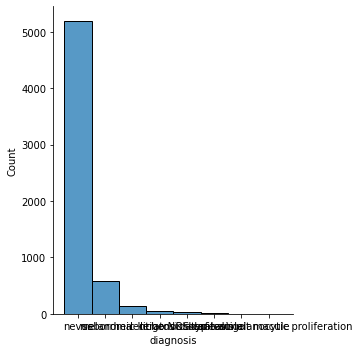

In [17]:
df['diagnosis'].value_counts()
sns.displot(data = df, x="diagnosis")

In [18]:
df[(df['diagnosis'] == 'atypical melanocytic proliferation') | (df['diagnosis'] == 'cafe-au-lait macule') | (df['diagnosis'] == 'solar lentigo')]['target']

4176     0
9792     0
9987     0
13765    0
23051    0
24242    0
24485    0
27630    0
30473    0
Name: target, dtype: int64

atypical melanocytic proliferation, cafe-au-lait macule and solar lentigo are few in numbers and all have target as 0. Hence we are removing them

In [19]:
df = df[~df['diagnosis'].isin(['atypical melanocytic proliferation','cafe-au-lait macule','solar lentigo'])]

In [20]:
df['target'].value_counts()/ df.shape[0] * 100

0    90.255298
1     9.744702
Name: target, dtype: float64

We could still see a huge target class imbalance in data

In [21]:
df['anatom_site_general_challenge'].value_counts()

torso              3341
lower extremity    1607
upper extremity     716
head/neck           259
palms/soles           7
oral/genital          5
Name: anatom_site_general_challenge, dtype: int64

anatom_site_general_challenge  target
head/neck                      0          185
                               1           74
lower extremity                0         1483
                               1          124
oral/genital                   0            1
                               1            4
palms/soles                    0            2
                               1            5
torso                          0         3084
                               1          257
upper extremity                0          605
                               1          111
Name: image_name, dtype: int64


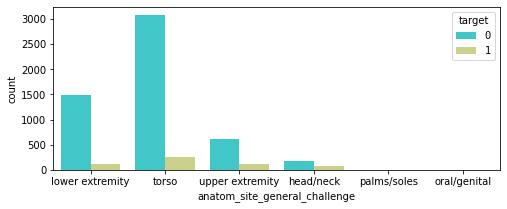

In [22]:
print(df.groupby(['anatom_site_general_challenge','target'])['image_name'].count())
plt.figure(figsize=(8,3))
sns.countplot(x='anatom_site_general_challenge',data=df, palette='rainbow', hue = 'target')
plt.show()

sex     target
female  0         2407
        1          220
male    0         3002
        1          364
Name: image_name, dtype: int64


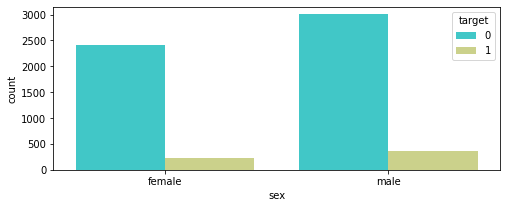

In [23]:
print(df.groupby(['sex','target'])['image_name'].count())
plt.figure(figsize=(8,3))
sns.countplot(x='sex',data=df, palette='rainbow', hue = 'target')
plt.show()

age_approx  target
15.0        0           1
            1           2
20.0        0          15
            1           6
25.0        0          99
            1          16
30.0        0         287
            1          24
35.0        0         457
            1          25
40.0        0         627
            1          24
45.0        0         824
            1          54
50.0        0         926
            1          53
55.0        0         796
            1          64
60.0        0         475
            1          65
65.0        0         324
            1          70
70.0        0         262
            1          58
75.0        0         200
            1          62
80.0        0          75
            1          36
85.0        0          34
            1           9
90.0        0           4
            1          16
Name: image_name, dtype: int64


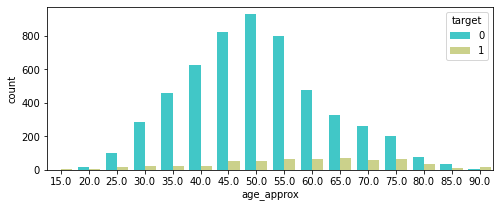

In [24]:
print(df.groupby(['age_approx','target'])['image_name'].count())
plt.figure(figsize=(8,3))
sns.countplot(x='age_approx',data=df, palette='rainbow', hue = 'target')
plt.show()

diagnosis             target
lentigo NOS           0           44
lichenoid keratosis   0           37
melanoma              1          584
nevus                 0         5193
seborrheic keratosis  0          135
Name: image_name, dtype: int64


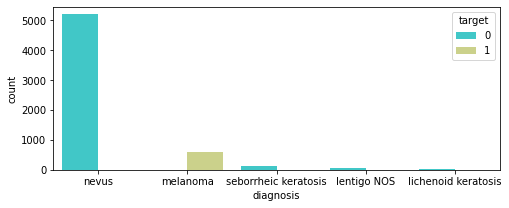

In [25]:
print(df.groupby(['diagnosis','target'])['image_name'].count())
plt.figure(figsize=(8,3))
sns.countplot(x='diagnosis',data=df, palette='rainbow', hue = 'target')
plt.show()

## Making data as image path and target columns

In [26]:
labels=[]
data=[]
for i in range(df.shape[0]):
    data.append(train_dir + df['image_name'].iloc[i]+'.png')
    labels.append(df['target'].iloc[i])
data=pd.DataFrame(data)
data.columns=['images']
data['target']=labels
data.head()

,images,target
0,../input/siic-isic-224x224-images/train/ISIC_0...,0
1,../input/siic-isic-224x224-images/train/ISIC_0...,0
2,../input/siic-isic-224x224-images/train/ISIC_0...,0
3,../input/siic-isic-224x224-images/train/ISIC_0...,0
4,../input/siic-isic-224x224-images/train/ISIC_0...,0


## Splitting the data into train and validation using Stratified Shuffle Split

In [27]:
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=1234)
for train_index, val_index in sss.split(data['images'], data['target']):
    print("TRAIN:", train_index, "TEST:", val_index)
    X_train, X_val = data['images'][train_index], data['images'][val_index]
    y_train, y_val = data['target'][train_index], data['target'][val_index]

TRAIN: [3860  288 4854 ... 4288  994 4609] TEST: [4951 2647 1453 ... 2493 3029 3347]
TRAIN: [ 196  545  992 ... 1628 3625  737] TEST: [2840  591 4739 ... 5408 1006 5347]
TRAIN: [ 646 2138  402 ...  584   10  293] TEST: [5118 4910 2974 ... 2029 3412 2416]
TRAIN: [5933 4826  630 ... 3057 2261 5199] TEST: [3719 2295   98 ... 4167 4465  389]
TRAIN: [3935 2560 3746 ... 2285 5036 3811] TEST: [5133  195  230 ... 5240 3152 3967]
TRAIN: [5351 3914 1061 ... 1092 4522 1738] TEST: [ 912 1388 2641 ... 3424 3608   25]
TRAIN: [4518 2996   60 ... 4456  250  325] TEST: [ 812 1248 1913 ...  194 1006  377]
TRAIN: [5891 3741  136 ... 4657  670  177] TEST: [1645 5712 5412 ...  975 5191 3463]
TRAIN: [ 324 5196  498 ... 3685 1451 3445] TEST: [3683 5293 5229 ...  575 3250 4867]
TRAIN: [3710 3281 3286 ... 5713 4632 3527] TEST: [3167 1115 4617 ... 5331 4640 1400]


In [28]:
train=pd.DataFrame(X_train)
train.columns=['images']
train['target']=y_train

validation=pd.DataFrame(X_val)
validation.columns=['images']
validation['target']=y_val

## Image Data Augmentation

In [29]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    width_shift_range=1.0,
    height_shift_range=1.0,
    zoom_range=1.0,
    shear_range=1.0,
    brightness_range=None,
    horizontal_flip=True,
    vertical_flip=True)

val_datagen=ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_dataframe(
    train,
    x_col='images',
    y_col='target',
    target_size=(224,224),
    batch_size=32,
    shuffle=True,
    class_mode='raw') #raw since target is numerical, should use 'categorical' if target is str

validation_generator = val_datagen.flow_from_dataframe(
    validation,
    x_col='images',
    y_col='target',
    target_size=(224, 224),
    shuffle=False, # shuffle should be false for validation, true for train
    batch_size=32,
    class_mode='raw')

Found 4794 validated image filenames.
Found 1199 validated image filenames.


## Model Build

In [30]:
IMAGE_SIZE = [224,224]
model = tf.keras.Sequential([
    efn.EfficientNetB4(
        input_shape=(*IMAGE_SIZE, 3),
        weights='imagenet',
        include_top=False
    ),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation= 'relu'), 
    tf.keras.layers.Dropout(0.25), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

2022-11-26 01:16:40.690230: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 01:16:40.851321: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 01:16:40.852211: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 01:16:40.853857: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

71901184/71892840 [==============================] - 3s 0us/step


## Model Compile

In [31]:
model.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy','AUC']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Functional) (None, 7, 7, 1792)        17673816  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               918016    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 18,592,345
Trainable params: 18,467,145
Non-trainable params: 125,200
_________________________________________________________________


## Model Fit

In [32]:
model.fit(train_generator, epochs=20, validation_data=validation_generator)

2022-11-26 01:16:52.386274: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-11-26 01:17:09.691938: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


150/150 [==============================] - 142s 791ms/step - loss: 0.2774 - accuracy: 0.8901 - auc: 0.8114 - val_loss: 0.2515 - val_accuracy: 0.9024 - val_auc: 0.8538
Epoch 2/20
150/150 [==============================] - 94s 627ms/step - loss: 0.2283 - accuracy: 0.9078 - auc: 0.8764 - val_loss: 0.2620 - val_accuracy: 0.9058 - val_auc: 0.8270
Epoch 3/20
150/150 [==============================] - 94s 622ms/step - loss: 0.2204 - accuracy: 0.9053 - auc: 0.8887 - val_loss: 0.2901 - val_accuracy: 0.9041 - val_auc: 0.8168
Epoch 4/20
150/150 [==============================] - 92s 614ms/step - loss: 0.2086 - accuracy: 0.9139 - auc: 0.8991 - val_loss: 0.2059 - val_accuracy: 0.9258 - val_auc: 0.9120
Epoch 5/20
150/150 [==============================] - 93s 621ms/step - loss: 0.2069 - accuracy: 0.9172 - auc: 0.9006 - val_loss: 0.2200 - val_accuracy: 0.9066 - val_auc: 0.8837
Epoch 6/20
150/150 [==============================] - 93s 618ms/step - loss: 0.1975 - accuracy: 0.9186 - auc: 0.9081 - val_lo

Trying with Leaky Relu

In [33]:
from tensorflow.keras.layers import LeakyReLU
IMAGE_SIZE = [224,224]
model = tf.keras.Sequential([
    efn.EfficientNetB4(
        input_shape=(*IMAGE_SIZE, 3),
        weights='imagenet',
        include_top=False
    ),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation= LeakyReLU(alpha=0.01)), 
    tf.keras.layers.Dropout(0.25), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [34]:
model.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy','AUC']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Functional) (None, 7, 7, 1792)        17673816  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1792)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               918016    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 18,592,345
Trainable params: 18,467,145
Non-trainable params: 125,200
_________________________________________________________________


In [35]:
model.fit(train_generator, epochs=20, validation_data=validation_generator)

Epoch 1/20
150/150 [==============================] - 111s 633ms/step - loss: 0.2837 - accuracy: 0.8911 - auc: 0.8170 - val_loss: 0.5514 - val_accuracy: 0.9024 - val_auc: 0.7203
Epoch 2/20
150/150 [==============================] - 93s 619ms/step - loss: 0.2327 - accuracy: 0.9084 - auc: 0.8750 - val_loss: 0.2680 - val_accuracy: 0.8749 - val_auc: 0.8102
Epoch 3/20
150/150 [==============================] - 92s 612ms/step - loss: 0.2167 - accuracy: 0.9078 - auc: 0.8865 - val_loss: 0.2103 - val_accuracy: 0.9074 - val_auc: 0.9084
Epoch 4/20
150/150 [==============================] - 92s 610ms/step - loss: 0.2171 - accuracy: 0.9109 - auc: 0.8859 - val_loss: 0.2015 - val_accuracy: 0.9308 - val_auc: 0.9155
Epoch 5/20
150/150 [==============================] - 92s 609ms/step - loss: 0.2071 - accuracy: 0.9111 - auc: 0.8963 - val_loss: 0.2009 - val_accuracy: 0.9249 - val_auc: 0.9092
Epoch 6/20
150/150 [==============================] - 92s 612ms/step - loss: 0.1998 - accuracy: 0.9191 - auc: 0.90